In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import timedelta
from sklearn.decomposition import PCA

import haversine
import tensorflow as tf
from sklearn.model_selection import train_test_split

/Users/xuan/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
train.shape

(1458644, 11)

In [7]:
test.shape

(625134, 9)

In [8]:
# Check for any duplicates
print(train.duplicated().sum())
print(train.id.duplicated().sum())
print(test.id.duplicated().sum())

0
0
0


In [9]:
# Sanity check to ensure all trips are valid
sum(train.pickup_datetime > train.dropoff_datetime)

0

## clearning data

In [17]:
# drop feature since it will not be used to make any predictions.
# it is not included in the test dataframe
train=train.drop("dropoff_datetime",1)

In [18]:
# Some of the journeys are very long,maybe outliers
train.trip_duration.describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [12]:
# outliers in minute
print(train.trip_duration.max()/60)
print(np.percentile(train.trip_duration,99)/60)
print(np.percentile(train.trip_duration,99.5)/60)
print(np.percentile(train.trip_duration, 99.99)/60)
print(np.percentile(train.trip_duration, 99.999)/60)
print(np.percentile(train.trip_duration, 99.9999)/60)

58771
57.333333333333336
68.98333333333333
1438.7833333333333
1439.4833333333333
35765.9658686484


In [13]:
# Check how many trips remain with each limit
print(len(train[train.trip_duration<=np.percentile(train.trip_duration,99)]))
print(len(train[train.trip_duration<=np.percentile(train.trip_duration,99.99)]))
print(len(train[train.trip_duration<=np.percentile(train.trip_duration,99.999)]))

1444069
1458505
1458630


In [19]:
# Remove outliers
train = train[train.trip_duration <= np.percentile(train.trip_duration, 99.999)]

Text(0.5,1,u'Dropoff')

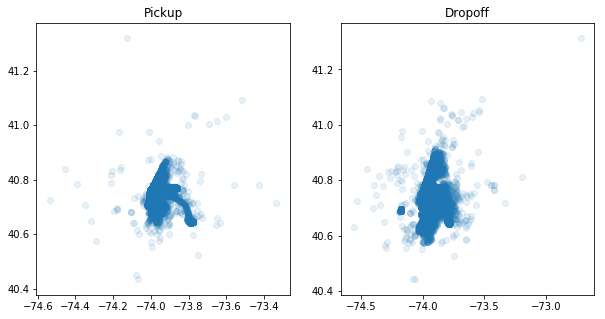

In [15]:
# outliers for location
f,(ax1,ax2) =plt.subplots(1,2,figsize=(10,5))
ax1.scatter(train.pickup_longitude[:100000],
           train.pickup_latitude[:100000],
           alpha=0.1)
ax1.set_title("Pickup")

ax2.scatter(train.dropoff_longitude[:100000],
           train.dropoff_latitude[:100000],
           alpha=0.1)
ax2.set_title("Dropoff")

In [16]:
# The values are not too wild, but we'll trim them back a little to be conservative
print(train.pickup_latitude.max())
print(train.pickup_latitude.min())
print(train.pickup_longitude.max())
print(train.pickup_longitude.min())
print
print(train.dropoff_latitude.max())
print(train.dropoff_latitude.min())
print(train.dropoff_longitude.max())
print(train.dropoff_longitude.min())

51.88108444213867
34.359695434570305
-61.33552932739258
-121.93334197998048

43.92102813720703
32.1811408996582
-61.33552932739258
-121.9333038330078


In [20]:
# Find limits of location
max_value = 99.999
min_value = 0.001

max_pickup_lat = np.percentile(train.pickup_latitude, max_value)
min_pickup_lat = np.percentile(train.pickup_latitude, min_value)
max_pickup_long = np.percentile(train.pickup_longitude, max_value)
min_pickup_long = np.percentile(train.pickup_longitude, min_value)

max_dropoff_lat = np.percentile(train.dropoff_latitude, max_value)
min_dropoff_lat = np.percentile(train.dropoff_latitude, min_value)
max_dropoff_long = np.percentile(train.dropoff_longitude, max_value)
min_dropoff_long = np.percentile(train.dropoff_longitude, min_value)

In [21]:
# Remove extreme values
train = train[(train.pickup_latitude <= max_pickup_lat) & (train.pickup_latitude >= min_pickup_lat)]
train = train[(train.pickup_longitude <= max_pickup_long) & (train.pickup_longitude >= min_pickup_long)]

train = train[(train.dropoff_latitude <= max_dropoff_lat) & (train.dropoff_latitude >= min_dropoff_lat)]
train = train[(train.dropoff_longitude <= max_dropoff_long) & (train.dropoff_longitude >= min_dropoff_long)]

Text(0.5,1,u'Dropoff')

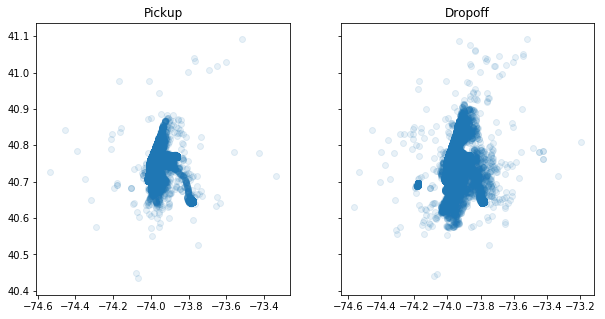

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude[:100000], 
            train.pickup_latitude[:100000],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude[:100000], 
            train.dropoff_latitude[:100000],
            alpha = 0.1)
ax2.set_title('Dropoff')

In [22]:
# Concatenate the datasets for feature engineering
df = pd.concat([train,test])

In [23]:
df.shape

(2083716, 10)

In [22]:
df.head()

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id
0,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,455.0,2
1,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,663.0,1
2,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,2124.0,2
3,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,429.0,2
4,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,435.0,2


In [23]:
# Check for null values
# trip_duration nulls to due to them not being present in the test set
df.isnull().sum()

dropoff_latitude           0
dropoff_longitude          0
id                         0
passenger_count            0
pickup_datetime            0
pickup_latitude            0
pickup_longitude           0
store_and_fwd_flag         0
trip_duration         625134
vendor_id                  0
dtype: int64

In [24]:
df.vendor_id.value_counts()

2    1114650
1     969066
Name: vendor_id, dtype: int64

In [25]:
print(train.pickup_datetime.max())
print(train.pickup_datetime.min())
print
print(test.pickup_datetime.max())
print(test.pickup_datetime.min())
print
print(df.pickup_datetime.max())
print(df.pickup_datetime.min())

2016-06-30 23:59:39
2016-01-01 00:00:17

2016-06-30 23:59:58
2016-01-01 00:00:22

2016-06-30 23:59:58
2016-01-01 00:00:17


In [25]:
# Convert to datetime
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

In [26]:
df.pickup_datetime.head()

0   2016-03-14 17:24:55
1   2016-06-12 00:43:35
2   2016-01-19 11:35:24
3   2016-04-06 19:32:31
4   2016-03-26 13:30:55
Name: pickup_datetime, dtype: datetime64[ns]

In [27]:
# Calculate what minute in a day for pickup 
df['pickup_minute_of_the_day']=df.pickup_datetime.dt.hour*60+df.pickup_datetime.dt.minute

In [28]:
df.pickup_minute_of_the_day.head()

0    1044
1      43
2     695
3    1172
4     810
Name: pickup_minute_of_the_day, dtype: int64

In [29]:
# Rather than use the standard 24 hours, group the trips into 24 groups that are sorted by KMeans
# This should help 'rush-hour' rides to be in the same groups,change to one column,not know how many rows -1
kmeans_pickup_time= KMeans(n_clusters=24,random_state=2).fit(df.pickup_minute_of_the_day[:500000].values.reshape(-1,1))

In [30]:
df['kmeans_pickup_time'] = kmeans_pickup_time.predict(df.pickup_minute_of_the_day.values.reshape(-1,1))
df.kmeans_pickup_time.head()

0     5
1     6
2     7
3    12
4     0
Name: kmeans_pickup_time, dtype: int32

Text(0.5,1,u'Pickup Hour')

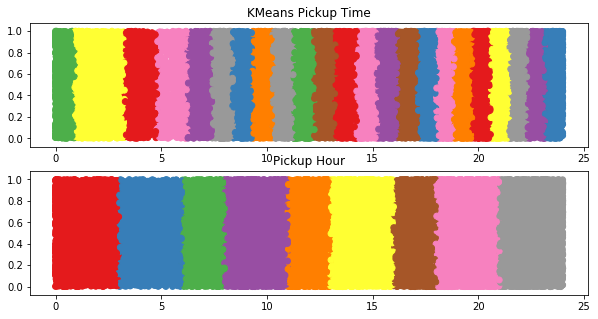

In [32]:
# Compare the distribution of kmeans_pickup_time and the standard 24 hour breakdown
n = 50000 # number of data points to plot
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,5))

ax1.scatter(x=df.pickup_minute_of_the_day[:n]/60,
           y=np.random.uniform(0,1,n),
           cmap='Set1',
           c=df.kmeans_pickup_time[:n])
ax1.set_title('KMeans Pickup Time')

ax2.scatter(x=df.pickup_minute_of_the_day[:n]/60,
           y=np.random.uniform(0,1,n),
           cmap='Set1',
           c=df.pickup_datetime.dt.hour[:n])
ax2.set_title('Pickup Hour')


In [31]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = df.pickup_datetime.min(), 
                                 end = df.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

In [32]:
# Create features relating to time
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_weekday'] = df.pickup_datetime.dt.weekday
df['pickup_is_weekend'] = df.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)

df['pickup_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
df['pickup_holiday'] = df.pickup_holiday.map(lambda x: 1 if x == True else 0)

df['pickup_near_holiday'] = (pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) |
                             pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
df['pickup_near_holiday'] = df.pickup_near_holiday.map(lambda x: 1 if x==True else 0 )

df['pickup_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
df['pickup_businessday'] = df.pickup_businessday.map(lambda x: 1 if x == True else 0)

# Calculates what minute of the week it is
df['week_delta'] = (df.pickup_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

In [33]:
# Determines number of rides that occur during each specific time
# Should help to determine traffic
ride_counts = df.groupby(['pickup_month', 'pickup_weekday','pickup_holiday','pickup_near_holiday',
            'pickup_businessday','kmeans_pickup_time']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)# Add `ride_counts` to dataframe
df = df.merge(ride_counts, on=['pickup_month',
                          'pickup_weekday',
                          'pickup_holiday',
                          'pickup_near_holiday',
                          'pickup_businessday',
                          'kmeans_pickup_time'], how='left')

In [34]:
# Dont' need this feature any more
df = df.drop('pickup_datetime', 1)

In [35]:
# Group pickup and dropoff locations into 15 groups
kmeans_pickup = KMeans(n_clusters=15,random_state=2).fit(df[['pickup_latitude','pickup_longitude']][:500000])
kmeans_dropoff = KMeans(n_clusters=15, random_state=2).fit(df[['dropoff_latitude','dropoff_longitude']][:500000])

df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])

Text(0.5,1,u'Dropoff')

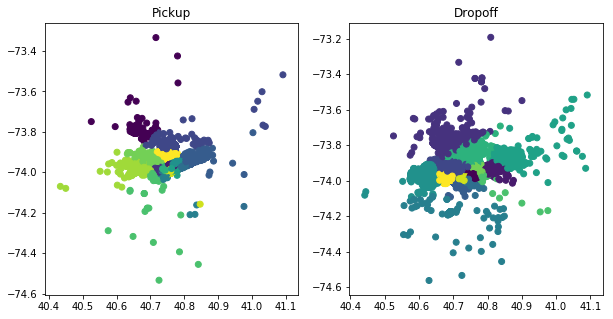

In [38]:
# Plot these 15 groups

n = 100000 # Number of data points to plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.scatter(df.pickup_latitude[:n],
            df.pickup_longitude[:n],
           cmap='viridis',
           c=df.kmeans_pickup[:n])
ax1.set_title('Pickup')

ax2.scatter(df.dropoff_latitude[:n],
            df.dropoff_longitude[:n],
           cmap='viridis',
           c=df.kmeans_dropoff[:n])
ax2.set_title('Dropoff')



In [36]:
# Reduce pickup and dropoff locations to one value
pca=PCA(n_components=1)
df['pickup_pca']=pca.fit_transform(df[['pickup_latitude','pickup_longitude']])
df['dropoff_pca'] = pca.fit_transform(df[['dropoff_latitude','dropoff_longitude']])

In [37]:
# Create distance features
df['distance'] = np.sqrt(np.power(df['dropoff_longitude'] - df['pickup_longitude'], 2) + 
                         np.power(df['dropoff_latitude'] - df['pickup_latitude'], 2))
df['haversine_distance'] = df.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])), 
                                                                  axis=1)
df['manhattan_distance'] = (abs(df.dropoff_longitude - df.pickup_longitude) +
                            abs(df.dropoff_latitude - df.pickup_latitude))
df['log_distance'] = np.log(df['distance'] + 1)
df['log_haversine_distance'] = np.log(df['haversine_distance'] + 1)
df['log_manhattan_distance'] = np.log(df.manhattan_distance + 1)


In [38]:
# Calculate the direction of travel in degrees
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [39]:
df['bearing'] = calculate_bearing(df.pickup_latitude,
                                  df.pickup_longitude,
                                  df.dropoff_latitude,
                                  df.dropoff_longitude)

In [43]:
df.passenger_count.value_counts()

1    1476947
2     300329
5     111497
3      85581
6      68853
4      40419
0         83
9          3
7          3
8          1
Name: passenger_count, dtype: int64

In [40]:
# Group passenger_count by type of group
df['no_passengers']=df.passenger_count.map(lambda x: 1 if x==0 else 0)
df['one_passenger'] = df.passenger_count.map(lambda x: 1 if x == 1 else 0)
df['few_passengers'] = df.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
df['many_passengers'] = df.passenger_count.map(lambda x: 1 if x >= 5 else 0)

In [41]:
df.store_and_fwd_flag = df.store_and_fwd_flag.map(lambda x: 1 if x == 'Y' else 0)

In [42]:
df['pickup_month'].head()

0    3
1    6
2    1
3    4
4    3
Name: pickup_month, dtype: int64

In [43]:
# Create dummy features for these features, then drop these features
dummies = ['kmeans_pickup_time','pickup_month','pickup_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features=pd.get_dummies(df[feature],prefix=feature)
    for dummy in dummy_features:
        df[dummy]=dummy_features[dummy]
    df=df.drop([feature],axis=1)

In [153]:
df.head()

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,pickup_minute_of_the_day,...,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,40.765602,-73.964630,id2875421,1,40.767937,-73.982155,0,455.0,2,1044,...,0,0,0,0,0,0,1,0,0,0
1,40.731152,-73.999481,id2377394,1,40.738564,-73.980415,0,663.0,1,43,...,0,0,0,0,0,0,0,0,1,0
2,40.710087,-74.005333,id3858529,1,40.763939,-73.979027,0,2124.0,2,695,...,0,0,0,0,0,0,0,0,0,0
3,40.706718,-74.012268,id3504673,1,40.719971,-74.010040,0,429.0,2,1172,...,0,0,0,0,0,0,0,0,0,0
4,40.782520,-73.972923,id2181028,1,40.793209,-73.973053,0,435.0,2,810,...,0,0,0,0,0,1,0,0,0,0


In [44]:
# Don't need this feature any more
df = df.drop(['id'],1)

In [45]:
# Transform each feature to have a mean of 0 and standard deviation of 1
# Help to train the neural network
for feature in df:
    if feature == 'trip_duration':
        continue
    mean,std=df[feature].mean(),df[feature].std()
    df.loc[:,feature]=(df[feature]-mean)/std

In [156]:
# Check that the transformation was carried out correctly
df.head()

,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,pickup_minute_of_the_day,pickup_is_weekend,...,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,0.411094,0.174547,-0.505345,0.592172,-0.168330,-0.074414,455.0,0.932411,0.515206,-0.631483,...,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,2.416877,-0.0024,-0.401036,-0.15753
1,-0.616539,-0.520763,-0.505345,-0.430931,-0.134548,-0.074414,663.0,-1.072488,-2.090069,1.583573,...,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,-0.413757,-0.0024,2.493543,-0.15753
2,-1.244885,-0.637510,-0.505345,0.452924,-0.107582,-0.074414,2124.0,0.932411,-0.393127,-0.631483,...,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,-0.413757,-0.0024,-0.401036,-0.15753
3,-1.345361,-0.775872,-0.505345,-1.078542,-0.709873,-0.074414,429.0,0.932411,0.848348,-0.631483,...,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,-0.413757,-0.0024,-0.401036,-0.15753
4,0.915751,0.009092,-0.505345,1.472439,0.008431,-0.074414,435.0,0.932411,-0.093819,1.583573,...,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,3.303164,-0.413757,-0.0024,-0.401036,-0.15753


In [46]:
# Return data into a training and testing set
trainFinal = df[:-len(test)]
testFinal = df[-len(test):]

In [51]:
# Check lengths of dataframes
print(len(trainFinal))
print(len(testFinal))
print(len(test))

1458582
625134
625134


In [47]:
# Give trip_duration its own dataframe
# Drop it from the other dataframes
yFinal = pd.DataFrame(trainFinal.trip_duration)
trainFinal = trainFinal.drop('trip_duration',1)
testFinal = testFinal.drop('trip_duration',1)

In [48]:
# Sort data into training and testing sets
x_trainFinal,x_testFinal,y_trainFinal,y_testFinal=train_test_split(trainFinal,
                                                                   np.log(yFinal+1),
                                                                   test_size=0.15,
                                                                   random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x_trainFinal, 
                                                    y_trainFinal, 
                                                    test_size=0.15,
                                                    random_state=2)

## Build random forest

In [173]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error

initial_preds = {} # stores the RMSE and predictions for x_testFinal
final_preds = {} # store the predictions for testFinal, with x_testFinal's RMSE
num_iterations = 15
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_rfr = pd.DataFrame(columns=["RMSE",
                                    "n_estimators", 
                                    "max_depth", 
                                    "min_samples_split"])

for i in range(num_iterations):
    # Use random search to choose the inputs' values
    n_estimators = np.random.randint(10,20)
    max_depth = np.random.randint(6,12)
    min_samples_split = np.random.randint(2,50)

    rfr = RFR(n_estimators = n_estimators,
          max_depth = max_depth,
          min_samples_split = min_samples_split,
          verbose = 2,
          random_state = 2)
    
    rfr = rfr.fit(x_train, y_train.values)

    y_preds_rfr = rfr.predict(x_testFinal)
    RMSE_rfr = np.sqrt(mean_squared_error(y_testFinal, y_preds_rfr))
    print("RMSE for iteration #{} is {}.".format(i+1, RMSE_rfr))
    print("NE={}, MD={}, MSS={}".format(n_estimators,
                                        max_depth,
                                        min_samples_split))
    print
    
    initial_preds[RMSE_rfr] = y_preds_rfr
    testFinal_preds_rfr = rfr.predict(testFinal)
    final_preds[RMSE_rfr] = [testFinal_preds_rfr]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE_rfr,
                             n_estimators, 
                             max_depth, 
                             min_samples_split]],
                     columns = ["RMSE",
                                "n_estimators", 
                                "max_depth", 
                                "min_samples_split"])
    
    # Append the dataframe as a new row in results_df
    results_rfr = results_rfr.append(new_row, ignore_index=True)

/Users/xuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished


RMSE for iteration #1 is 0.456855058295.
NE=11, MD=7, MSS=16



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished


building tree 1 of 15


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s


building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished


RMSE for iteration #2 is 0.42821102022.
NE=15, MD=11, MSS=4



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished


building tree 1 of 18


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


building tree 2 of 18
building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18
building tree 9 of 18
building tree 10 of 18
building tree 11 of 18
building tree 12 of 18
building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.3s finished


RMSE for iteration #3 is 0.439769890135.
NE=18, MD=9, MSS=19



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished


RMSE for iteration #4 is 0.456852591564.
NE=11, MD=7, MSS=9



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 50.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished


RMSE for iteration #5 is 0.433752600753.
NE=11, MD=10, MSS=49



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s finished


building tree 1 of 17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17
building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


RMSE for iteration #6 is 0.456600928103.
NE=17, MD=7, MSS=22



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.6s finished


building tree 1 of 15


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s remaining:    0.0s


building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


RMSE for iteration #7 is 0.433217879603.
NE=15, MD=10, MSS=20



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


RMSE for iteration #8 is 0.447530889993.
NE=10, MD=8, MSS=21



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


building tree 1 of 13


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s


building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 72.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished


RMSE for iteration #9 is 0.45680709751.
NE=13, MD=7, MSS=20



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.4s finished


building tree 1 of 17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.9min remaining:    0.0s


building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17
building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 80.8min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished


RMSE for iteration #10 is 0.433175029333.
NE=17, MD=10, MSS=20



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.9min remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 71.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.5min finished


RMSE for iteration #11 is 0.428761687926.
NE=10, MD=11, MSS=24



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 18


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


building tree 2 of 18
building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18
building tree 9 of 18
building tree 10 of 18
building tree 11 of 18
building tree 12 of 18
building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 74.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.3s finished


RMSE for iteration #12 is 0.447075077283.
NE=18, MD=8, MSS=33



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.7s finished


building tree 1 of 19


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


building tree 2 of 19
building tree 3 of 19
building tree 4 of 19
building tree 5 of 19
building tree 6 of 19
building tree 7 of 19
building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 86.8min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


RMSE for iteration #13 is 0.439842818735.
NE=19, MD=9, MSS=46



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 11.6min finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 25.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


RMSE for iteration #14 is 0.467962091501.
NE=10, MD=6, MSS=27



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.9min remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 61.8min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.3s finished


RMSE for iteration #15 is 0.428541496641.
NE=11, MD=11, MSS=18



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s finished


In [186]:
# Check the results
results_rfr

,RMSE,n_estimators,max_depth,min_samples_split
0,0.456855,11,7,16
1,0.428211,15,11,4
2,0.439770,18,9,19
3,0.456853,11,7,9
4,0.433753,11,10,49
5,0.456601,17,7,22
6,0.433218,15,10,20
7,0.447531,10,8,21
8,0.456807,13,7,20
9,0.433175,17,10,20


In [187]:
np.array([0]*len(x_testFinal))

array([0, 0, 0, ..., 0, 0, 0])

In [188]:
sorted_initial_RMSE = sorted(initial_preds)
print(sorted_initial_RMSE)

[0.4282110202200761, 0.42854149664053526, 0.4287616879262411, 0.43317502933295576, 0.43321787960323904, 0.43375260075256783, 0.4397698901347102, 0.43984281873536046, 0.44707507728311563, 0.44753088999262297, 0.4566009281031706, 0.4568070975096298, 0.4568525915636711, 0.4568550582949483, 0.46796209150084006]


In [189]:
initial_preds

{0.4282110202200761: array([6.62355815, 5.31780773, 5.92945812, ..., 6.04090368, 5.7827711 ,
        5.95793513]),
 0.42854149664053526: array([6.62612394, 5.29827897, 5.94544423, ..., 6.02070292, 5.79397715,
        5.95361189]),
 0.4287616879262411: array([6.62860321, 5.2874987 , 5.94405284, ..., 6.0219115 , 5.80077764,
        5.9360246 ]),
 0.43317502933295576: array([6.63226592, 5.38385483, 5.88447222, ..., 5.99449697, 5.76648907,
        5.8711668 ]),
 0.43321787960323904: array([6.62955412, 5.38887693, 5.88731125, ..., 6.01568324, 5.76272196,
        5.87102506]),
 0.43375260075256783: array([6.63016257, 5.39802468, 5.88268972, ..., 6.0021647 , 5.77926457,
        5.87432338]),
 0.4397698901347102: array([6.68350691, 5.54808258, 5.8035301 , ..., 6.00724179, 5.72236111,
        5.8958531 ]),
 0.43984281873536046: array([6.68200262, 5.5580221 , 5.79521353, ..., 6.00602176, 5.72558959,
        5.90296564]),
 0.44707507728311563: array([6.72902714, 5.7307737 , 5.84812251, ..., 5.930

In [192]:
for model in sorted_initial_RMSE:
    predictions = initial_preds[model]
    RMSE = np.sqrt(mean_squared_error(y_testFinal, predictions))
    print("RMSE = ", RMSE)

('RMSE = ', 0.4282110202200761)
('RMSE = ', 0.42854149664053526)
('RMSE = ', 0.4287616879262411)
('RMSE = ', 0.43317502933295576)
('RMSE = ', 0.43321787960323904)
('RMSE = ', 0.43375260075256783)
('RMSE = ', 0.4397698901347102)
('RMSE = ', 0.43984281873536046)
('RMSE = ', 0.44707507728311563)
('RMSE = ', 0.44753088999262297)
('RMSE = ', 0.4566009281031706)
('RMSE = ', 0.4568070975096298)
('RMSE = ', 0.4568525915636711)
('RMSE = ', 0.4568550582949483)
('RMSE = ', 0.46796209150084006)


In [198]:
a[RMSE_rfr] = y_preds_rfr

In [197]:
a={}

In [199]:
a

{0.42854149664053526: array([6.62612394, 5.29827897, 5.94544423, ..., 6.02070292, 5.79397715,
        5.95361189])}

In [205]:
predictions = final_preds[model][0]
best_predictions = pd.DataFrame(np.exp(predictions)-1)

In [211]:
# Prepare the dataframe for submitting to Kaggle
best_predictions['id'] = test.id
best_predictions['trip_duration'] = best_predictions[0]
best_predictions = best_predictions.drop([0],1)

#best_predictions.to_csv("submission_combined.csv", index=False)# Preview the predictions


In [212]:
best_predictions.head()

,id,trip_duration
0,id3004672,696.889603
1,id3505355,696.889603
2,id1217141,390.825226
3,id2150126,1196.679408
4,id1598245,390.825226


## build lightgbm

In [59]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [67]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_lgb = pd.DataFrame(columns=["RMSE",
                                    "num_leaves", 
                                    "max_depth", 
                                    "feature_fraction",
                                    "bagging_fraction",
                                    "bagging_freq",
                                    "learning_rate"])
for i in range(num_iterations):
    
    num_leaves = np.random.randint(100,250)
    max_depth = np.random.randint(6,12)
    feature_fraction = np.random.uniform(0.7,1)
    bagging_fraction = np.random.uniform(0.8,1)
    bagging_freq = np.random.randint(3,10)
    learning_rate = np.random.uniform(0.2,1)
    n_estimators = 100
    early_stopping_rounds = 5

    gbm = lgb.LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            num_leaves = num_leaves,
                            max_depth = max_depth,
                            feature_fraction = feature_fraction,
                            bagging_fraction = bagging_fraction,
                            bagging_freq = bagging_freq,
                            learning_rate = learning_rate,
                            n_estimators = n_estimators)
    
    gbm.fit(x_train.values, y_train.values.ravel(),
            eval_set = [(x_test.values, y_test.values.ravel())],
            eval_metric = 'rmse',
            early_stopping_rounds = early_stopping_rounds)

    y_preds_gbm = gbm.predict(x_testFinal, num_iteration = gbm.best_iteration_)
    RMSE_gbm = np.sqrt(mean_squared_error(y_testFinal, y_preds_gbm))
    print("RMSE for iteration #{} is {}.".format(i+1, RMSE_gbm))
    print("NL={}, MD={}, FF={}, BF={}, BQ={}, LR={}, NE={}, ESR={}".format(num_leaves,
                                                                           max_depth,
                                                                           feature_fraction,
                                                                           bagging_fraction,
                                                                           bagging_freq,
                                                                           learning_rate,
                                                                           n_estimators,
                                                                           early_stopping_rounds))
    print
    initial_preds[RMSE_gbm] = y_preds_gbm
    testFinal_preds_gbm = gbm.predict(testFinal, num_iteration = gbm.best_iteration_)
    final_preds[RMSE_gbm] = [testFinal_preds_gbm]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE_gbm,
                             num_leaves, 
                             max_depth, 
                             feature_fraction,
                             bagging_fraction,
                             bagging_freq,
                             learning_rate]],
                     columns = ["RMSE",
                                "num_leaves", 
                                "max_depth", 
                                "feature_fraction",
                                "bagging_fraction",
                                "bagging_freq",
                                "learning_rate"])
    
    # Append the dataframe as a new row in results_df
    results_lgb = results_lgb.append(new_row, ignore_index=True)

[1]	valid_0's rmse: 0.674189
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.587181
[3]	valid_0's rmse: 0.532617
[4]	valid_0's rmse: 0.49581
[5]	valid_0's rmse: 0.473334
[6]	valid_0's rmse: 0.454895
[7]	valid_0's rmse: 0.443008
[8]	valid_0's rmse: 0.434458
[9]	valid_0's rmse: 0.428749
[10]	valid_0's rmse: 0.423955
[11]	valid_0's rmse: 0.421128
[12]	valid_0's rmse: 0.418683
[13]	valid_0's rmse: 0.416752
[14]	valid_0's rmse: 0.414277
[15]	valid_0's rmse: 0.412963
[16]	valid_0's rmse: 0.411451
[17]	valid_0's rmse: 0.410154
[18]	valid_0's rmse: 0.40898
[19]	valid_0's rmse: 0.40832
[20]	valid_0's rmse: 0.407476
[21]	valid_0's rmse: 0.405977
[22]	valid_0's rmse: 0.405485
[23]	valid_0's rmse: 0.404569
[24]	valid_0's rmse: 0.403703
[25]	valid_0's rmse: 0.402997
[26]	valid_0's rmse: 0.402494
[27]	valid_0's rmse: 0.402028
[28]	valid_0's rmse: 0.401234
[29]	valid_0's rmse: 0.400874
[30]	valid_0's rmse: 0.400628
[31]	valid_0's rmse: 0.400481
[32]	valid_0's rmse: 

[2]	valid_0's rmse: 0.455314
[3]	valid_0's rmse: 0.434923
[4]	valid_0's rmse: 0.425912
[5]	valid_0's rmse: 0.421717
[6]	valid_0's rmse: 0.415834
[7]	valid_0's rmse: 0.414117
[8]	valid_0's rmse: 0.412778
[9]	valid_0's rmse: 0.410565
[10]	valid_0's rmse: 0.409694
[11]	valid_0's rmse: 0.409292
[12]	valid_0's rmse: 0.408908
[13]	valid_0's rmse: 0.407762
[14]	valid_0's rmse: 0.407144
[15]	valid_0's rmse: 0.407156
[16]	valid_0's rmse: 0.406482
[17]	valid_0's rmse: 0.406076
[18]	valid_0's rmse: 0.405643
[19]	valid_0's rmse: 0.405599
[20]	valid_0's rmse: 0.405356
[21]	valid_0's rmse: 0.404791
[22]	valid_0's rmse: 0.40454
[23]	valid_0's rmse: 0.404317
[24]	valid_0's rmse: 0.403884
[25]	valid_0's rmse: 0.403807
[26]	valid_0's rmse: 0.403858
[27]	valid_0's rmse: 0.403647
[28]	valid_0's rmse: 0.403333
[29]	valid_0's rmse: 0.403425
[30]	valid_0's rmse: 0.40362
[31]	valid_0's rmse: 0.403608
[32]	valid_0's rmse: 0.403432
[33]	valid_0's rmse: 0.403326
[34]	valid_0's rmse: 0.402898
[35]	valid_0's rmse:

RMSE for iteration #7 is 0.400439311391.
NL=103, MD=8, FF=0.770234541002, BF=0.967662201789, BQ=5, LR=0.62544316292, NE=100, ESR=5

[1]	valid_0's rmse: 0.462473
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.437056
[3]	valid_0's rmse: 0.429603
[4]	valid_0's rmse: 0.423713
[5]	valid_0's rmse: 0.42288
[6]	valid_0's rmse: 0.42041
[7]	valid_0's rmse: 0.419289
[8]	valid_0's rmse: 0.417365
[9]	valid_0's rmse: 0.416604
[10]	valid_0's rmse: 0.416661
[11]	valid_0's rmse: 0.416265
[12]	valid_0's rmse: 0.41591
[13]	valid_0's rmse: 0.415319
[14]	valid_0's rmse: 0.41452
[15]	valid_0's rmse: 0.414571
[16]	valid_0's rmse: 0.413951
[17]	valid_0's rmse: 0.413991
[18]	valid_0's rmse: 0.413472
[19]	valid_0's rmse: 0.413116
[20]	valid_0's rmse: 0.413255
[21]	valid_0's rmse: 0.413003
[22]	valid_0's rmse: 0.412659
[23]	valid_0's rmse: 0.412466
[24]	valid_0's rmse: 0.412513
[25]	valid_0's rmse: 0.412417
[26]	valid_0's rmse: 0.412363
[27]	valid_0's rmse: 0.412647
[28]	valid

[22]	valid_0's rmse: 0.405382
[23]	valid_0's rmse: 0.40505
[24]	valid_0's rmse: 0.404104
[25]	valid_0's rmse: 0.403735
[26]	valid_0's rmse: 0.403345
[27]	valid_0's rmse: 0.402744
[28]	valid_0's rmse: 0.402115
[29]	valid_0's rmse: 0.401714
[30]	valid_0's rmse: 0.401499
[31]	valid_0's rmse: 0.401147
[32]	valid_0's rmse: 0.400716
[33]	valid_0's rmse: 0.400325
[34]	valid_0's rmse: 0.400248
[35]	valid_0's rmse: 0.399614
[36]	valid_0's rmse: 0.399522
[37]	valid_0's rmse: 0.399344
[38]	valid_0's rmse: 0.398952
[39]	valid_0's rmse: 0.398793
[40]	valid_0's rmse: 0.398558
[41]	valid_0's rmse: 0.398313
[42]	valid_0's rmse: 0.398122
[43]	valid_0's rmse: 0.398071
[44]	valid_0's rmse: 0.397875
[45]	valid_0's rmse: 0.397569
[46]	valid_0's rmse: 0.39737
[47]	valid_0's rmse: 0.397256
[48]	valid_0's rmse: 0.397247
[49]	valid_0's rmse: 0.39726
[50]	valid_0's rmse: 0.397062
[51]	valid_0's rmse: 0.39673
[52]	valid_0's rmse: 0.396594
[53]	valid_0's rmse: 0.396383
[54]	valid_0's rmse: 0.396275
[55]	valid_0's